## ライブラリの読み込み

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import japanize_matplotlib
import pandas_datareader.data as web
import datetime
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from fuctions import *

In [14]:
import fuctions
import importlib
importlib.reload(fuctions)
from fuctions import *

## データの取得

In [2]:
code = 'BTC-JPY'
start = datetime.date(2019, 1, 1)
end = datetime.date(2022, 1, 1)
df = web.DataReader(code, 'yahoo', start=start, end=end)
print('欠損値の確認')
print(df.isnull().sum())
print('形状の確認', df.shape)
df.tail()

欠損値の確認
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64
形状の確認 (1098, 6)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-12-28,5817727.0,5443625.5,5817727.0,5461868.0,3836871215661,5461868.0
2021-12-29,5525821.0,5311208.5,5465887.0,5338808.0,3454151050818,5338808.0
2021-12-30,5512037.5,5295968.5,5344083.5,5428610.0,3070714447144,5428610.0
2021-12-31,5577297.5,5273212.5,5427603.0,5330242.5,4256023036571,5330242.5
2022-01-01,5505306.0,5328175.0,5330852.5,5489133.5,2829661633525,5489133.5


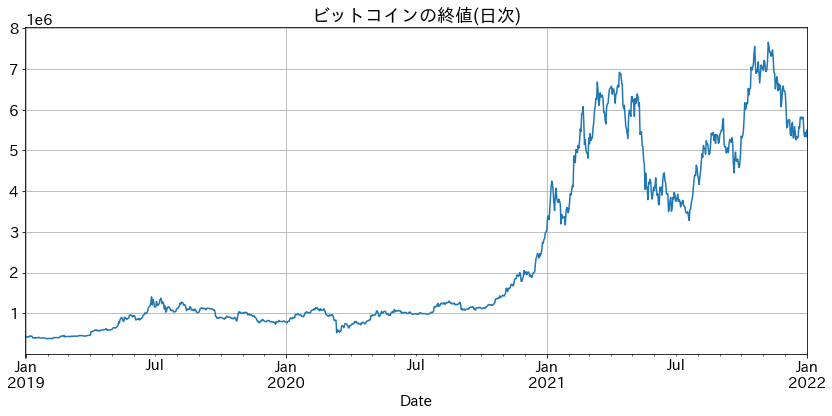

In [3]:
plt.rcParams["font.size"] = 15
df['Close'].plot(figsize=(14, 6))
plt.grid(True)
plt.title('ビットコインの終値(日次)')
plt.show()

## ドルバーの作成

In [45]:
threshold = 5000000000000000000
dollar_df = make_dollar_bar(df, threshold)
print('ドルバーの形状', dollar_df.shape)

欠損値削除後 (1098, 7)
ドルバーの形状 (672, 7)


/Users/kawashimayuuki/JupyterLab/finance_machine_learning/Section3/fuctions.py:12: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  df_dropped_list = df_dropped.to_dict('record')


In [5]:
dollar_df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,,
2019-01-21,2019-01-21,395593.90625,390169.09375,394928.50000,392196.00000,548844257224,392196.00000
2019-02-11,2019-02-11,405837.43750,402158.93750,405843.75000,402759.37500,692939952343,402759.37500
2019-02-25,2019-02-25,434861.59375,421660.75000,421726.40625,431157.90625,1034815028020,431157.90625
2019-03-09,2019-03-09,443243.12500,432697.59375,432937.93750,440583.59375,1200153801830,440583.59375
2019-03-20,2019-03-20,452793.40625,449940.50000,453561.75000,452351.62500,1126145354580,452351.62500


## リターンの作成

In [6]:
df_dropped = df.dropna().reset_index(drop=True)
df_dropped['PrevClose'] = df_dropped['Close'].shift(1)
df_dropped['CloseReturn'] = (df_dropped['Close'] - df_dropped['PrevClose']) / df_dropped['PrevClose']

dollar_df['PrevClose'] = dollar_df['Close'].shift(1)
dollar_df['CloseReturn'] = (dollar_df['Close'] - dollar_df['PrevClose']) / dollar_df['PrevClose']

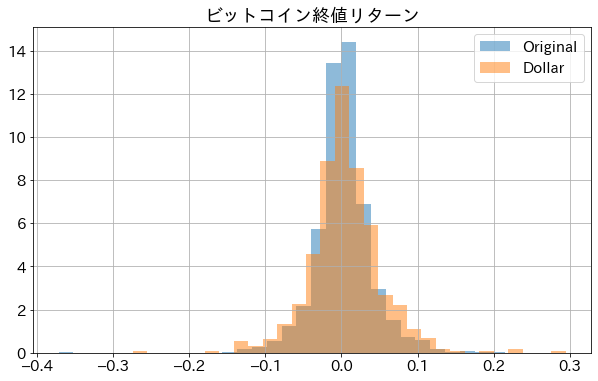

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(df_dropped['CloseReturn'].values, alpha=0.5, bins=30, density=True, label='Original')
plt.hist(dollar_df['CloseReturn'].values, alpha=0.5, bins=30, density=True, label='Dollar')
plt.legend()
plt.title('ビットコイン終値リターン')
plt.grid(True)
plt.show()

## ボリンジャーバンドモデル

In [47]:
vol_df = dollar_df.copy()
# compute bands
window = 20
vol_df['Avg'], vol_df['Upper'], vol_df['Lower'] = bbands(vol_df['Close'], window, no_of_stdev=1.0)

# compute sides
vol_df['Side'] = np.nan
long_signals = (vol_df['Close'] <= vol_df['Lower'])
short_signals = (vol_df['Close'] >= vol_df['Upper'])
vol_df.loc[long_signals, 'Side'] = 1
vol_df.loc[short_signals, 'Side'] = -1

print(vol_df['Side'].value_counts())

# Remove Look ahead biase by lagging the signal
vol_df['Side'] = vol_df['Side'].shift(1)

# Drop the NaN values from our data set
vol_df.dropna(axis=0, how='any', inplace=True)  

-1.0    159
 1.0     60
Name: Side, dtype: int64


In [48]:
# データの分割
X = vol_df['Close'].values.reshape(-1, 1)
y = vol_df['Side'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# パラメータの設定
n_estimator = 1000
depth = 2
RANDOM_STATE = 123

rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', class_weight='balanced_subsample',
                            random_state=RANDOM_STATE)

# モデルの訓練
model = rf.fit(X_train, y_train)

In [49]:
# モデルの評価
model.score(X_test, y_test)

0.5227272727272727

## トリプルバリア法

In [11]:
close = dollar_df['Close']

In [12]:
daily_vol = get_daily_vol(close, span0=50)
daily_vol.head()

Date
2019-02-11         NaN
2019-02-25    0.030813
2019-03-09    0.026805
2019-03-20    0.022654
2019-03-31    0.023551
Name: Close, dtype: float64

In [15]:
cusum_events = get_t_events(close, threshold=daily_vol.mean()*0.1)

Applying Symmetric CUSUM filter.


100%|██████████| 670/670 [00:00<00:00, 10216.66it/s]


In [16]:
cusum_df = df.loc[cusum_events]
cusum_df.shape

(579, 6)

In [17]:
labels = triple_barrier(cusum_df)

## ランダムフォレストによる予測

In [27]:
all_df = pd.concat([cusum_df, labels], axis=1)
all_df.head()

,High,Low,Open,Close,Volume,Adj Close,bin
2019-02-25,434861.59375,421660.75000,421726.40625,431157.90625,1034815028020,431157.90625,1.0
2019-03-09,443243.12500,432697.59375,432937.93750,440583.59375,1200153801830,440583.59375,1.0
2019-03-20,452793.40625,449940.50000,453561.75000,452351.62500,1126145354580,452351.62500,1.0
2019-03-31,456505.53125,454405.28125,455190.71875,455659.84375,1003920401210,455659.84375,1.0
2019-04-05,564490.56250,549582.62500,549685.68750,562726.25000,1881160317320,562726.25000,1.0


In [33]:
x = all_df['bin'].value_counts().index[-1]
all_df[all_df['bin'] == x] = 1

In [34]:
all_df['bin'].value_counts()

-1.0    293
 1.0    281
 0.0      5
Name: bin, dtype: int64

In [39]:
# データの分割
X = all_df['Close'].values.reshape(-1, 1)
y = all_df['bin'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# パラメータの設定
n_estimator = 1000
depth = 2
RANDOM_STATE = 123

rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', class_weight='balanced_subsample',
                            random_state=RANDOM_STATE)

# モデルの訓練
model = rf.fit(X_train, y_train)

In [40]:
# モデルの評価
model.score(X_test, y_test)

0.46551724137931033

In [24]:
model.feature_importances_

array([1.])